In [2]:
import os
import cdsapi 
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy
import cartopy.crs as ccrs
from cartopy.io import shapereader
import pandas as pd
import glob
import sys

# creds
sys.path.append('/Users/max/Deep_Sky/')
from creds import CDS_UID, CDS_API_key

In [3]:
import src.cdsretrieve as retrieve
import src.preprocess as preprocess

c = cdsapi.Client()

In [4]:
continental_us = [50, -120, 20, -80]
drought_area = [44.898, -111.066, 33.095, -90.631]

In [5]:
years = np.arange(1981, 2013)
print(years)
folder = '../../data/UNSEEN/heatwave-2012/map_plot_data/'

[1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012]


In [34]:
for year in years:
    if not os.path.isfile(folder + 'ERA5_' + str(year) + '.nc'):
        c.retrieve(
            'reanalysis-era5-single-levels-monthly-means',
            {'format': 'netcdf',
            'product_type': 'monthly_averaged_reanalysis',
            'variable': '2m_temperature',
            'area':[90, -180, -90, 180],
            'grid': [1.0, 1.0],
            'year':  str(year),
            'month': ['05', '06', '07'],
            'time': '00:00'
            },
            folder + 'ERA5_' + str(year) + '.nc')

2024-04-10 12:27:10,898 INFO Welcome to the CDS
2024-04-10 12:27:10,901 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2024-04-10 12:27:11,126 INFO Downloading https://download-0001-clone.copernicus-climate.eu/cache-compute-0001/cache/data5/adaptor.mars.internal-1712766408.6153767-17194-8-6f04e062-ce42-44b3-aadb-90f007c8675f.nc to ../../data/UNSEEN/heatwave-2012/map_plot_data/ERA5_1981.nc (385K)
2024-04-10 12:27:12,105 INFO Download rate 393.6K/s
2024-04-10 12:27:12,376 INFO Welcome to the CDS
2024-04-10 12:27:12,378 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2024-04-10 12:27:12,831 INFO Request is queued
2024-04-10 12:27:13,969 INFO Request is running
2024-04-10 12:27:15,600 INFO Request is completed
2024-04-10 12:27:15,602 INFO Downloading https://download-0004-clone.copernicus-climate.eu/cache-compute-0004/cache/data2/adaptor.mars.intern

In [7]:
ERA5 = xr.open_mfdataset('../../data/UNSEEN/heatwave/map_plot_data/ERA5_????.nc', combine='by_coords')
ERA5.sel(time='2012-07-01')['t2m'].load()


<xarray.DataArray 't2m' (latitude: 181, longitude: 360)>
array([[273.92056, 273.92056, 273.92056, ..., 273.92056, 273.92056,
        273.92056],
       [273.90738, 273.90903, 273.90903, ..., 273.92386, 273.9189 ,
        273.91232],
       [273.94034, 273.9354 , 273.93375, ..., 273.94034, 273.93375,
        273.9354 ],
       ...,
       [222.59799, 222.7183 , 222.83366, ..., 222.18271, 222.3063 ,
        222.45462],
       [217.18279, 217.19926, 217.21904, ..., 217.11028, 217.13335,
        217.15642],
       [216.70818, 216.70818, 216.70818, ..., 216.70818, 216.70818,
        216.70818]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
    time       datetime64[ns] 2012-07-01
Attributes:
    units:      K
    long_name:  2 metre temperature

In [8]:
def season_mean(ds, years, calendar='standard'):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = month_length.groupby('time.year') / month_length.groupby('time.year').sum()

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(years))

    # Calculate the weighted average
    return (ds * weights).groupby('time.year').sum(dim='time', min_count = 3)

In [9]:
ERA5_yearly = season_mean(ERA5, len(pd.to_datetime(ERA5.time.values).year.unique()))
ERA5_yearly.sel(year=2012)['t2m'].load()

<xarray.DataArray 't2m' (latitude: 181, longitude: 360)>
array([[270.97288049, 270.97288049, 270.97288049, ..., 270.97288049,
        270.97288049, 270.97288049],
       [271.07000202, 271.07109468, 271.07053939, ..., 271.08426036,
        271.0798718 , 271.07548324],
       [271.25494849, 271.25165259, 271.25002256, ..., 271.25444694,
        271.25113313, 271.25222579],
       ...,
       [223.3950595 , 223.53755851, 223.67616537, ..., 222.96728615,
        223.09539629, 223.24797489],
       [218.63124018, 218.65003038, 218.67046854, ..., 218.52577143,
        218.56091574, 218.59607796],
       [218.23528439, 218.23528439, 218.23528439, ..., 218.23528439,
        218.23528439, 218.23528439]])
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
    year       int64 2012

In [10]:
ERA5_anomaly = ERA5_yearly['t2m'] - ERA5_yearly['t2m'].sel(year=slice(1982, 2013)).mean('year')
ERA5_sd_anomaly = ERA5_anomaly / ERA5_yearly['t2m'].sel(year=slice(1982, 2013)).std('year')

In [15]:
import matplotlib.patches as mpatches
import cartopy.feature as cfeature


def plot_n_america(ERA5_input):

    extent = [-125, -70, 20, 60]
    central_lon = np.mean(extent[:2])
    central_lat = np.mean(extent[2:])

    plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
    ax.set_extent(extent)

    ERA5_input.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        extend='both',
        cbar_kwargs={'label': 'Standardized Temperature Anomaly'})


    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.coastlines(resolution='110m')  
    ax.set_title('')

# Add state borders
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')


    # Add a black box around the specified coordinates
    nebraska = [42.980712, -104.023496, 40.053028, -95.498106]

    drought_area = [44.898, -111.066, 33.095, -90.631]
    box = mpatches.Rectangle((nebraska[1], nebraska[2]), nebraska[3]-nebraska[1], nebraska[0]-nebraska[2], 
                             fill=False, edgecolor='black', linewidth=1, transform=ccrs.PlateCarree())
    ax.add_patch(box)
    #plt.savefig('../../figures/UNSEEN/anomaly_map_large_test.png')
    return ax



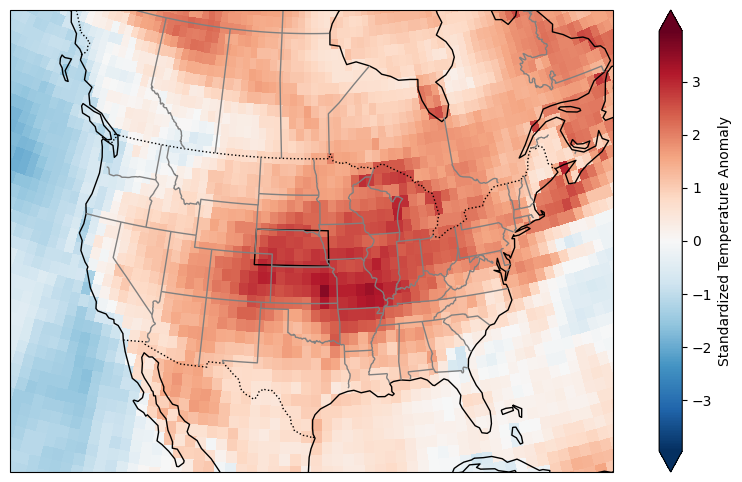

In [16]:
temperature = ERA5_sd_anomaly.sel(year=2012)
anomaly_map = plot_n_america(temperature)


In [41]:
plt.savefig('../../figures/UNSEEN/anomaly_map.png')

<Figure size 640x480 with 0 Axes>